In [1]:
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from neurodiffeq import diff      
from neurodiffeq.ode import IVP, solve_system, Monitor, ExampleGenerator, Solution, _trial_solution
from neurodiffeq.networks import FCNN, SinActv 
from scipy.special import roots_legendre

In [2]:
torch.set_default_tensor_type('torch.DoubleTensor')

In [3]:
FROM, TO = 0., 5.
N_NODE = 8
QUADRATURE_DEGREE = 32
TRAIN_SIZE = 10 # the training set is not actually used
VALID_SIZE = 10
MAX_EPOCHS = 10000

q_points, q_weights = roots_legendre(QUADRATURE_DEGREE)
global_q_points  = FROM + torch.tensor(q_points).reshape(-1, 1) * (TO-FROM)
global_q_points.requires_grad = True
global_q_weights = torch.tensor(q_weights).reshape(-1, 1)

In [4]:
def solve_system_quadrature(
        ode_system, conditions, t_min, t_max,
        single_net=None, nets=None, train_generator=None, shuffle=True, valid_generator=None,
        optimizer=None, criterion=None, additional_loss_term=None, metrics=None, batch_size=16,
        max_epochs=1000,
        monitor=None, return_internal=False,
        return_best=False,
):
    ########################################### subroutines ###########################################
    def train(train_generator, net, nets, ode_system, conditions, criterion, additional_loss_term, shuffle, optimizer):
        train_examples_t = train_generator.get_examples()
        train_examples_t = train_examples_t.reshape((-1, 1))
        n_examples_train = train_generator.size
        idx = np.random.permutation(n_examples_train) if shuffle else np.arange(n_examples_train)

        batch_start, batch_end = 0, batch_size
        while batch_start < n_examples_train:
            if batch_end > n_examples_train:
                batch_end = n_examples_train
            batch_idx = idx[batch_start:batch_end]
            ts = train_examples_t[batch_idx]

            train_loss_batch = calculate_loss(ts, net, nets, ode_system, conditions, criterion, additional_loss_term)

            optimizer.zero_grad()
            train_loss_batch.backward()
            optimizer.step()

            batch_start += batch_size
            batch_end += batch_size

        train_loss_epoch = calculate_loss(train_examples_t, net, nets, ode_system, conditions, criterion, additional_loss_term)
        
        train_metrics_epoch = calculate_metrics(train_examples_t, net, nets, conditions, metrics)
        return train_loss_epoch, train_metrics_epoch

    def valid(valid_generator, net, nets, ode_system, conditions, criterion, additional_loss_term):
        valid_examples_t = valid_generator.get_examples()
        valid_examples_t = valid_examples_t.reshape((-1, 1))
        valid_loss_epoch = calculate_loss(valid_examples_t, net, nets, ode_system, conditions, criterion, additional_loss_term)
        valid_loss_epoch = valid_loss_epoch.item()

        valid_metrics_epoch = calculate_metrics(valid_examples_t, net, nets, conditions, metrics)
        return valid_loss_epoch, valid_metrics_epoch

    # calculate the loss with Gaussian quadrature
    # uses global variables, just for convenience
    def calculate_loss(ts, net, nets, ode_system, conditions, criterion, additional_loss_term):
        ts = global_q_points
        ws = global_q_weights
        us = _trial_solution(net, nets, ts, conditions)
        Futs = ode_system(*us, ts)
        loss = sum(
            torch.sum(ws * Fut**2) for Fut in Futs
        )
        return loss
    
    def calculate_metrics(ts, net, nets, conditions, metrics):
        us = _trial_solution(net, nets, ts, conditions)
        metrics_ = {
            metric_name: metric_function(*us, ts).item()
            for metric_name, metric_function in metrics.items()
        }
        return metrics_
    ###################################################################################################

    if single_net and nets:
        raise RuntimeError('Only one of net and nets should be specified')
    # defaults to use a single neural network
    if (not single_net) and (not nets):
        single_net = FCNN(n_input_units=1, n_output_units=len(conditions), n_hidden_units=32, n_hidden_layers=1,
                   actv=nn.Tanh)
    if single_net:
        # mark the Conditions so that we know which condition correspond to which output unit
        for ith, con in enumerate(conditions):
            con.set_impose_on(ith)
    if not train_generator:
        if (t_min is None) or (t_max is None):
            raise RuntimeError('Please specify t_min and t_max when train_generator is not specified')
        train_generator = ExampleGenerator(32, t_min, t_max, method='equally-spaced-noisy')
    if not valid_generator:
        if (t_min is None) or (t_max is None):
            raise RuntimeError('Please specify t_min and t_max when train_generator is not specified')
        valid_generator = ExampleGenerator(32, t_min, t_max, method='equally-spaced')
    if (not optimizer) and single_net:  # using a single net
        optimizer = optim.Adam(single_net.parameters(), lr=0.001)
    if (not optimizer) and nets:  # using multiple nets
        all_parameters = []
        for net in nets:
            all_parameters += list(net.parameters())
        optimizer = optim.Adam(all_parameters, lr=0.001)
    if not criterion:
        criterion = nn.MSELoss()
    if metrics is None:
        metrics = {}

    history = {}
    history['train_loss'] = []
    history['valid_loss'] = []
    for metric_name, _ in metrics.items():
        history['train__' + metric_name] = []
        history['valid__' + metric_name] = []

    if return_best:
        valid_loss_epoch_min = np.inf
        solution_min = None

    for epoch in range(max_epochs):
        train_loss_epoch, train_metrics_epoch = train(train_generator, single_net, nets, ode_system, conditions, criterion, additional_loss_term, shuffle,
                                 optimizer)
        history['train_loss'].append(train_loss_epoch)
        for metric_name, metric_value in train_metrics_epoch.items():
            history['train__'+metric_name].append(metric_value)

        valid_loss_epoch, valid_metrics_epoch = valid(valid_generator, single_net, nets, ode_system, conditions, criterion, additional_loss_term,)
        history['valid_loss'].append(valid_loss_epoch)
        for metric_name, metric_value in valid_metrics_epoch.items():
            history['valid__'+metric_name].append(metric_value)

        if monitor and epoch % monitor.check_every == 0:
            monitor.check(single_net, nets, conditions, history)

        if return_best and valid_loss_epoch < valid_loss_epoch_min:
            valid_loss_epoch_min = valid_loss_epoch
            solution_min = Solution(single_net, nets, conditions)

    if return_best:
        solution = solution_min
    else:
        solution = Solution(single_net, nets, conditions)

    if return_internal:
        internal = {
            'single_net': single_net,
            'nets': nets,
            'conditions': conditions,
            'train_generator': train_generator,
            'valid_generator': valid_generator,
            'optimizer': optimizer,
            'criterion': criterion
        }
        return solution, history, internal
    else:
        return solution, history

<IPython.core.display.Javascript object>


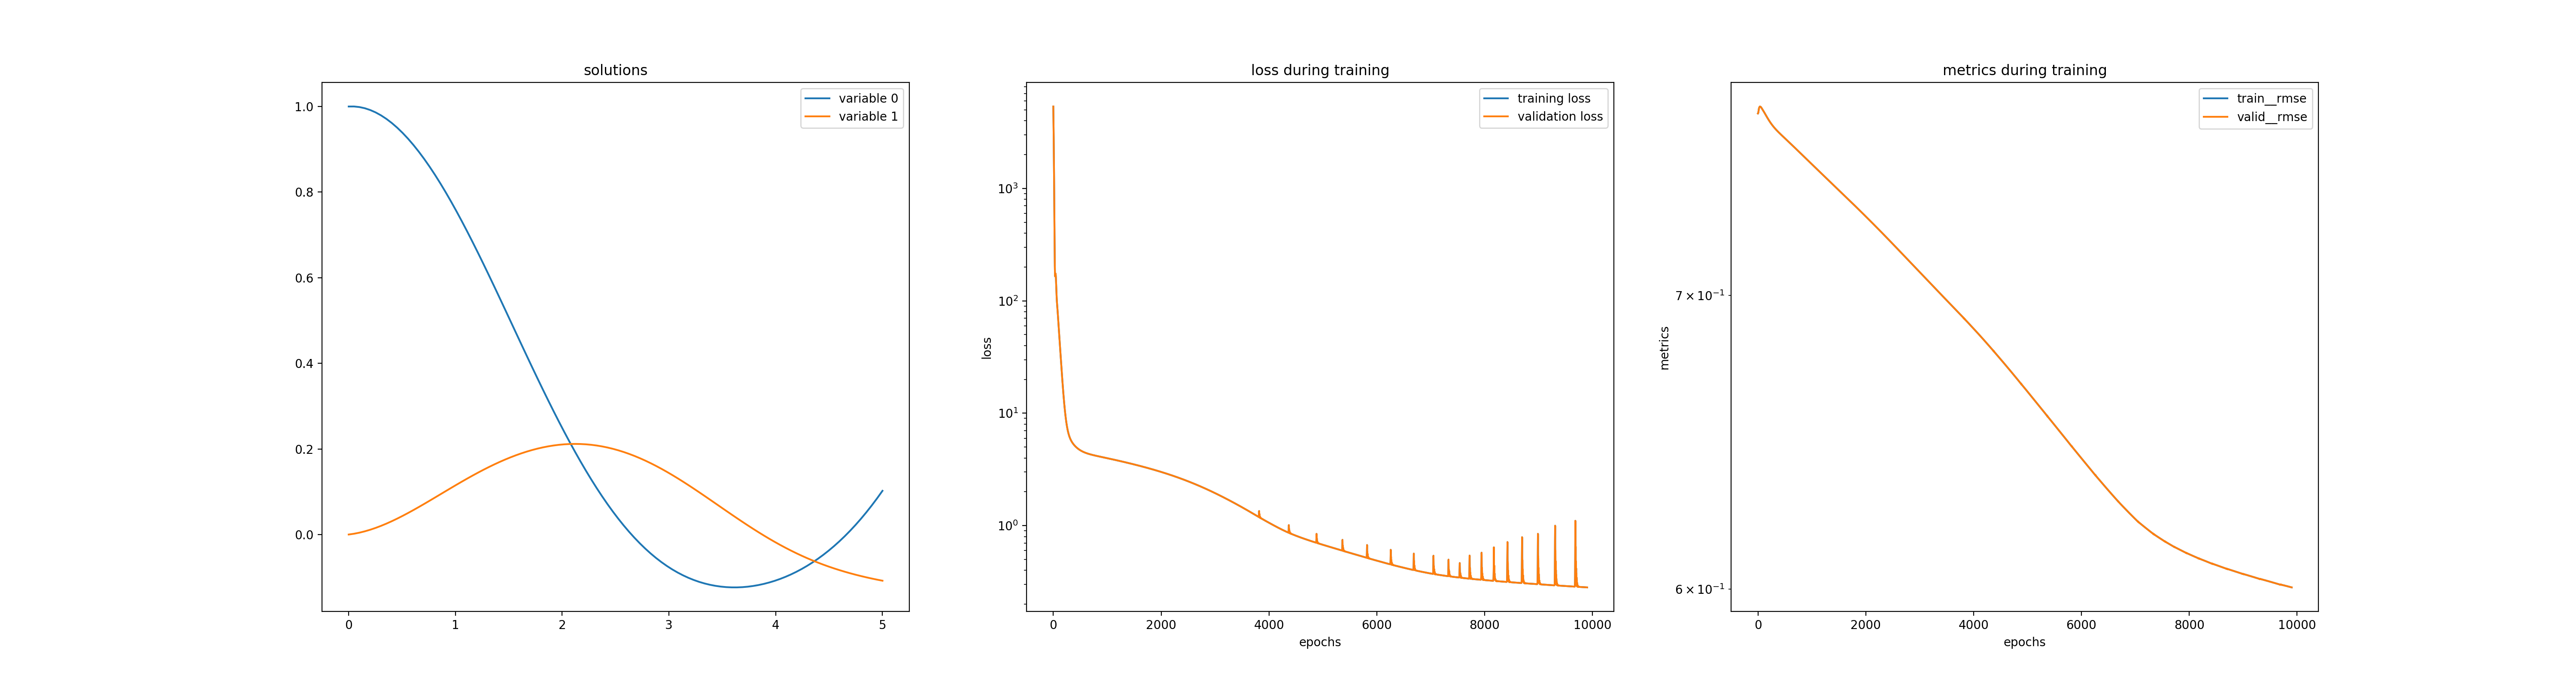

In [5]:
%matplotlib notebook

odes = lambda x, y, t : [diff(x, t) + t*y,
                         diff(y, t) - t*x]

ivps = [
    IVP(t_0=0., x_0=1.),
    IVP(t_0=0., x_0=0.)
]

nets = [
    FCNN(n_hidden_units=N_NODE, n_hidden_layers=1, actv=SinActv),
    FCNN(n_hidden_units=N_NODE, n_hidden_layers=1, actv=SinActv)
]

train_gen = ExampleGenerator(TRAIN_SIZE, t_min=FROM, t_max=TO, method='equally-spaced')
valid_gen = ExampleGenerator(VALID_SIZE, t_min=FROM, t_max=TO, method='equally-spaced')

def rmse(x, y, t):
    true_x = torch.cos(t**2/2)
    true_y = torch.sin(t**2/2)
    x_sse = torch.sum((x - true_x) ** 2)
    y_sse = torch.sum((y - true_y) ** 2)
    return torch.sqrt( (x_sse+y_sse)/(len(x)+len(y)) )

solution, _ = solve_system_quadrature(
    ode_system=odes, 
    conditions=ivps, 
    t_min=FROM, t_max=TO,
    nets=nets,
    train_generator=train_gen,
    valid_generator=valid_gen,
    batch_size=TRAIN_SIZE,
    max_epochs=MAX_EPOCHS,
    monitor=Monitor(t_min=FROM, t_max=TO, check_every=100),
    metrics={'rmse': rmse}
)